In [1]:
from osgeo import gdal
from osgeo import gdalconst
import os

In [2]:
# move to directory
# os.chdir(r'D:\Tugas Univesitas Udayana\SMT 5\Penginderaan Jauh\TIMUR_LC08_L1TP_116066_20170911_20170927_01_T1')
os.chdir(r'D:\Tugas Univesitas Udayana\SMT 5\Penginderaan Jauh\USE_LC08_L1TP_116066_20210602_20210608_01_T1\cropped')

print(gdalconst.GA_ReadOnly)

# band3 = gdal.Open('LC08_L1TP_116066_20170911_20170927_01_T1_B3.TIF', gdalconst.GA_ReadOnly)
# band6 = gdal.Open('LC08_L1TP_116066_20170911_20170927_01_T1_B6.TIF', gdalconst.GA_ReadOnly)
band3 = gdal.Open('LC08_L1TP_116066_20210602_20210608_01_T1_B3_CROPPED.TIF', gdalconst.GA_ReadOnly)
band6 = gdal.Open('LC08_L1TP_116066_20210602_20210608_01_T1_B6_CROPPED.TIF', gdalconst.GA_ReadOnly)
arrBand3 = band3.GetRasterBand(1).ReadAsArray()
arrBand6 = band6.GetRasterBand(1).ReadAsArray()

0


In [3]:
mtl = open('../LC08_L1TP_116066_20210602_20210608_01_T1_MTL.txt', 'r')
attribs = mtl.readlines()

for ilines in attribs:
    if 'SPACECRAFT_ID = ' in ilines:
        spacecraft_id = ilines.split('=')[1][2:11]
        print(spacecraft_id + " is verified.")
        break

if spacecraft_id != "LANDSAT_8":
    print("This is not a Landsat 8 scene and will not be processed. Thank you.")

multFinished = False
addFinished = False
pathFinished = False
rowFinished = False

for line in attribs:
    if multFinished and addFinished and pathFinished and rowFinished:
        break
    if "REFLECTANCE_MULT_BAND_3 = " in line and not multFinished:
        multBandValue = float(line.split('=')[1])
        print("REFLECTANCE_MULT_BAND_3 = ", multBandValue)
        multFinished = True
    elif "REFLECTANCE_ADD_BAND_3 = " in line and not addFinished:
        addBandValue = float(line.split('=')[1])
        print("REFLECTANCE_ADD_BAND_3 = ", addBandValue)
        addFinished = True
    elif "WRS_PATH = " in line and not pathFinished:
        path = int(line.split('=')[1])
        print("WRS_PATH = ", path)
        pathFinished = True
    elif "WRS_ROW = " in line and not rowFinished:
        row = int(line.split('=')[1])
        print("WRS_ROW = ", row)
        rowFinished = True

LANDSAT_8 is verified.
WRS_PATH =  116
WRS_ROW =  66
REFLECTANCE_MULT_BAND_3 =  2e-05
REFLECTANCE_ADD_BAND_3 =  -0.1


In [4]:
# colom
cols = band3.RasterXSize
# baris
rows = band3.RasterYSize 
# count band on 1 file
bands = band3.RasterCount

print (cols, rows, bands)

93 101 3


In [5]:
import rasterio
band3 = rasterio.open('LC08_L1TP_116066_20210602_20210608_01_T1_B3_CROPPED.TIF')
band6 = rasterio.open('LC08_L1TP_116066_20210602_20210608_01_T1_B6_CROPPED.TIF')
arrBand3 = band3.read(1).astype('float64')
arrBand6 = band6.read(1).astype('float64')

In [6]:
import numpy as np

# koreksi reflektance
b3Corrected = (multBandValue * arrBand3 + addBandValue)
b6Corrected = (multBandValue * arrBand6 + addBandValue)

# koreksi radiance
# b3Corrected = (0.0001169 * arrBand3 - 58.4)
# b6Corrected = (0.0001500 * arrBand6 - 7.5)

In [7]:
import numpy as np

mask = arrBand3 == 0
gswir = np.where(
    (arrBand3+arrBand6)==0., 
    0, 
    (arrBand3-arrBand6)/(arrBand3+arrBand6)
)

gswir[abs(gswir) > 1] = np.nan
if mask is not None:
    gswir[mask] = np.nan

# gswir = np.divide(arrBand3-arrBand6, arrBand3+arrBand6, where=(arrBand3-arrBand6)!=0)

In [8]:
from pylandtemp import ndvi
mask = arrBand3 == 0
ndviImage = ndvi(arrBand3, arrBand6, mask=mask)

In [9]:
danau = np.count_nonzero(ndviImage >= 0.6)
print(danau * 900/1000000)

3.6513


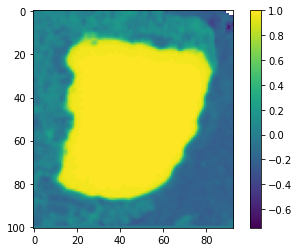

In [10]:
import matplotlib.pyplot as plt

plt.imshow(ndviImage)
plt.colorbar()
plt.show()

[-0.66666667 -0.6        -0.5        ...  0.96875     1.
         nan]


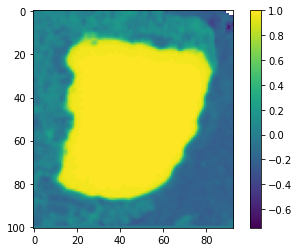

In [11]:
import matplotlib.pyplot as plt
print(np.unique(gswir)[1:])

plt.imshow(gswir)
plt.colorbar()
plt.show()

In [12]:
# tanpa koreksi
# danau = np.count_nonzero(gswir >= 0.7)
# danau = (gswir >= 0.7).sum() # cara lain

# dengan koreksi reflectance
danauOffset = np.count_nonzero(gswir >= -0.0055)
danau = np.count_nonzero(gswir >= -0.008)
danau = danau - danauOffset
print(danau * 900/1000000)

0.0225


In [13]:
res = [j for i in gswir for j in i]
print(len(res)*900/1000000)

8.4537


In [14]:
res = (gswir)
print(res)
print(res*900)
print(res*900/1000000)

[[-0.06220096  0.00904977  0.06140351 ...         nan         nan
          nan]
 [ 0.01538462  0.02892562  0.05353319 ... -0.36842105         nan
          nan]
 [ 0.03238866  0.03658537  0.02752294 ... -0.18918919 -0.39130435
  -0.46666667]
 ...
 [-0.1840796  -0.15226337 -0.14376997 ... -0.09929078 -0.05119454
  -0.04733728]
 [-0.19277108 -0.1959799  -0.14950166 ... -0.09157509 -0.04225352
  -0.04878049]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ -55.98086124    8.14479638   55.26315789 ...           nan
            nan           nan]
 [  13.84615385   26.03305785   48.17987152 ... -331.57894737
            nan           nan]
 [  29.14979757   32.92682927   24.7706422  ... -170.27027027
  -352.17391304 -420.        ]
 ...
 [-165.67164179 -137.03703704 -129.39297125 ...  -89.36170213
   -46.07508532  -42.6035503 ]
 [-173.4939759  -176.38190955 -134.55149502 ...  -82.41758242
   -38.02816901  -43.90243902]
 [   0.            0.            0.         ..

In [ ]:
gs = band3.GetGeoTransform()
print (gs)

In [ ]:
x0 = gs[0]
y0 = gs[3]  
pwidth = gs[1]  
pheight = gs[5]  

# nilai 0 di x, nilai 0 di y, lebar dan tinggi
# karena citra tidak dimulai dari pojok kiri atas citra (ada kemiringan)
print (x0, y0, pwidth, pheight)

264885.0 -843585.0 30.0 -30.0
